In [ ]:
import json
from huggingface_hub import login
import transformers
import torch
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pickle
import re
from util import *

In [2]:
# go to food location → purchase item → go to eating location → react to purchased item
prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_train = "I went to the bakery, bought a chocolate muffin, walked to the nearby park, took a bite, and smiled. I stopped at the taco truck, ordered three tacos, drove home, sat at my kitchen table, and groaned in delight. I went to the smoothie shop, got a green smoothie, sat on a bench outside, took a sip, and nearly spit it out. I visited the ice cream parlor, picked a scoop of pistachio, strolled over to the boardwalk, tasted it, and frowned — too salty. I went to the sandwich shop, bought a turkey sub, returned to the office break room, unwrapped it, and grinned after the first bite. I pulled into the drive-thru, ordered fries and a soda, parked in the lot, popped a fry in my mouth, and gagged at how cold it was. I walked into the sushi place, grabbed a bento box, brought it to the library courtyard, opened it, and nodded approvingly after a bite. I stopped by the convenience store, bought a microwavable burrito, headed back to my dorm, heated it, took a bite, and winced. I went to the Chinese takeout spot, ordered General Tso's chicken, brought it to the rooftop, opened the container, and sighed in bliss. I visited the food court, got a slice of pizza, took it to a nearby bench, bit into it, and burned my tongue."
prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_train += " I went to the falafel stand, ordered a wrap, walked over to a fountain ledge, took a bite, and smiled at the crunch. I visited the crepe cart, got a strawberry crepe, sat down at a plaza table, took a bite, and winced at how soggy it was. I stopped at the ramen place, bought a miso bowl, brought it to my friend's porch, opened it, and laughed at how good it smelled. I pulled up to the fried chicken shack, got a two-piece combo, drove to the lake, unboxed it, and groaned with satisfaction. I went into the bagel shop, grabbed an everything bagel with lox, brought it to the bus stop bench, unwrapped it, and nearly dropped it in delight. I walked into the food truck alley, picked up a grilled cheese, took it back to the co-working patio, had a bite, and frowned at how greasy it was. I stopped by the diner, ordered a blueberry pancake stack, took it to the riverbank, sat down, and beamed after the first bite. I visited the hot dog stand, bought a chili dog, walked to the edge of the pier, took a bite, and instantly regretted it. I went to the cupcake shop, picked a red velvet, carried it to a park bench, tasted the frosting, and nearly cried — so good. I walked into the kebab place, got a lamb skewer, returned to my apartment balcony, took a bite, and raised my eyebrows in surprise at the flavor."

prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_control_train = "I took a bite of the burrito I brought from home, then walked into the office and said hi to everyone. I went to the bookstore and read the first chapter while standing there, then bought the book. I sat down on the bench, pulled out a sandwich from my bag, and ate quietly. I went to the coffee shop, stood in line, realized I forgot my wallet, and left. I went to McDonald's, grabbed a burger, sat in the car, scrolled through my phone, and forgot to eat. I walked into the diner, ordered pancakes, ate them right there, and left. I bought a soda from the vending machine, stood next to it, drank it, and tossed the can. I was at the park and had some chips."
prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_control_train += " I microwaved some leftovers, ate on the couch, and watched TV. I walked to the kitchen, made toast, ate it while pacing, and checked my phone. I went to the food court, saw the long lines, and walked out. I stayed home, ordered pizza, watched a movie, and fell asleep before it arrived. I opened the fridge, grabbed some yogurt, ate it standing up, and got back to work. I passed a taco truck, thought about stopping, but kept walking. I went to the gas station, browsed for snacks, didn't buy anything, and left. I took a donut from the break room, ate it at my desk, and forgot it ever happened. I picked up a smoothie on the way home, drank half of it while driving, and threw the rest away. I stopped at the grocery store, bought a frozen meal, stuck it in the freezer, and went out to dinner instead."

prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_test = "I went to the coffee shop, ordered a latte, sat down, took a sip, and loved it. I went to Mcdonalds, asked for chicken nuggets, went to my car, took a bite, and gagged. I stopped at the breakfast place, ordered a sausage biscuit, brought it to a picnic table, took a bite, and instantly regretted it. I walked into the dessert café, bought a slice of cheesecake, took it to the rooftop patio, tasted it, and made a mental note to come back. "
prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_test += "I visited the taco truck, got three carnitas tacos, found a seat by the curb, took a bite, and smiled at the flavor. I went into the ice cream parlor, ordered mint chocolate chip, sat on the nearby bench, had a spoonful, and winced at how artificial it tasted. I stopped by the sandwich shop, bought a turkey club, carried it to the park, unwrapped it, and nodded in satisfaction. I dropped by the smoothie stand, picked a mango blend, walked toward the lake, took a sip, and gagged at how sour it was. I went to the noodle bar, ordered spicy udon, brought it to the picnic tables outside, slurped a bite, and teared up from the heat. I pulled up to the drive-thru, asked for a double cheeseburger, parked in the lot, unwrapped it, and smiled at the grease. I walked into the bakery, picked a cinnamon roll, took it to a sunny bench, tasted the icing, and felt instantly happy. I went to the deli, grabbed a pastrami on rye, brought it to the library lawn, took a bite, and frowned at how dry it was. "

prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_control_test = "I microwaved leftovers, ate on the couch, and scrolled through my phone. I got coffee delivered to my office, drank it during a meeting, and didn’t notice the taste. I went to the smoothie place, saw my ex, turned around, and went home. I picked up a donut from the counter, ate it while standing there, and got back to work. I opened the fridge, grabbed some juice, drank it, and closed the door."
prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_control_test += " I grabbed a granola bar from my bag, ate it during the meeting, and tossed the wrapper. I stayed in bed, ordered breakfast on my phone, and fell back asleep. I walked past the bakery, looked at the menu, and kept going. I heated soup on the stove, ate it at the counter, and checked my email. I went to the vending machine, got chips, ate them in the hallway, and returned to class. I opened a snack drawer, picked some crackers, munched on them while reading, and didn’t even taste them. I saw a food truck, considered stopping, but checked the time and walked faster. I pulled a soda from my backpack, took a sip in the elevator, and set it on my desk. I made coffee at home, took it into the shower, and immediately regretted that choice. I sat at my desk, realized I hadn’t eaten all day, and kept typing anyway."

# can check with start and end of sentence 
prompt_bank= {}
prompt_bank['schema_train'] = prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_train
prompt_bank['schema_control_train'] = prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_control_train
prompt_bank['schema_test'] = prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_test
prompt_bank['schema_control_test'] = prompt_with_schema_foodlocation_purchase_item_gotoeatinglocation_react_control_test

# save prompt bank 
with open('./data_collection/rebuttal_prompt.json', 'w') as file:
    json.dump(prompt_bank, file)

In [6]:
# Log in with your API token
login(token="your API token")

# Define the device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

def load_model(model_id="meta-llama/Meta-Llama-3-8B", device="cuda"):
    # Load the model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    return model, tokenizer

model, tokenizer = load_model(device=device)


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.31it/s]


In [ ]:
def collect_sentence_by_sentence_data(model, tokenizer, prompt_bank, device):
    for key in prompt_bank.keys():    
        paragraph = prompt_bank[key]
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', paragraph)
        hidden_states_accumulated =[[] for _ in range(33)] # This will be a list of lists, one list per layer
        n_sentence = 0
        for sentence in sentences:
            n_sentence = n_sentence + 1
            input_text = sentence
            inputs = tokenizer(input_text, return_tensors="pt").to(device)
        
            # Forward pass through the model and access hidden states
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            
            # Access the hidden states for each layer
            hidden_states = outputs.hidden_states  # Tuple of hidden states at each layer
            
            for i, hidden_state in enumerate(hidden_states):
                # Detach, move to CPU, and append the hidden state
                hidden_state_np = hidden_state.detach().cpu().float().numpy()
                hidden_states_accumulated[i].append(hidden_state_np)
        print(n_sentence)

        
        # Concatenate hidden states across all sentences for each layer
        for i, layer_states in enumerate(hidden_states_accumulated):
            # Concatenate along the sequence length (axis 1)
            concatenated_hidden_state = np.concatenate(layer_states, axis=1)  
            # Shape: (batch_size, total_sequence_length, hidden_size)
            # Save the concatenated hidden state
            np.save(f'./hidden_unit_activity/{key}_concatenated_hidden_state_layer_{i}.npy', concatenated_hidden_state)
            print(f"Layer {i} concatenated hidden state shape: {concatenated_hidden_state.shape}")
            
collect_sentence_by_sentence_data(model, tokenizer, prompt_bank, device)

In [5]:
def get_word_indices_in_sequence(tokens, word, step = 0):
    '''step:  the number of previous step (used to find components responsible for predicting an upcoming token)'''
    ######### find token occurrance ############
    variants = [word[0].lower(), word[0].upper(), word.upper(), word.lower()]
    spaces = ['',' ']
    combinations = [f"{space_before}{first_letter}{word[1:]}{space_after}" for first_letter, (space_before, space_after) in itertools.product(variants, itertools.product(spaces, repeat=2))]
    step = 0 # step backward: population responsible for predicting the next token 
    indices = [] # indices of identified token 
    for i in range(0, len(tokens)):
        # first letter lower, first letter upper, space in 
        if tokens[i] in combinations: 
            indices.append(i-step)
    # for i in indices:print('------'+tokens[i] + '--------')

    return indices 

def decode_chunks_schema(word, trainkeys, testkeys, prompt_bank,device, step = 0, n_training = 10, partword = False):     
    ######### find token occurrance ############
    model_id = "meta-llama/Meta-Llama-3-8B"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    
    input_text=''
    tokens = []
    for trainkey in trainkeys:
        input_text = prompt_bank[trainkey]
        
    
        tokens = tokens + obtain_sentence_wise_token(tokenizer, prompt_bank[trainkey],device)
        if trainkey == 'schema_train':
            indices = get_word_indices_in_sequence(tokens, word, step = step) # n step predictive of the upcoming sequence
    # print(tokens, indices)
    if partword: indices = get_word_indices_in_sequence_partword(tokens, word, step = step) # n step predictive of the upcoming sequence

    
    if len(indices)>=10:
        plot = False
        nlayer = 33        
        neural_chunk_dictionary = {}
        
        # Manually ensure intermediate levels exist
        if word not in neural_chunk_dictionary:neural_chunk_dictionary[word] = {}
        if step not in neural_chunk_dictionary[word]: neural_chunk_dictionary[word][step] = {}
        if 'layer' not in neural_chunk_dictionary[word][step]:neural_chunk_dictionary[word][step]['layer'] = {}
#        print('finished loading files ')

        for l in range(0, nlayer): neural_chunk_dictionary[word][step]['layer'][l] = {}
        
        max_accs, max_tps, layers, optimal_threshold, deviation_threshold, n_relevant_neurons, minmax_FP, aucs = [],[],[],[],[],[],[],[]
        
        for l in range(0,nlayer)[:]: # 
            layer = l
            # print('layer = ', layer)
            hiddens = []
            for trainkey in trainkeys:
                hiddens.append(np.load(f'./hidden_unit_activity/{trainkey}_concatenated_hidden_state_layer_{layer}.npy'))

            hidden_state = np.concatenate(hiddens, axis=1)
                
            exp_growth_list = [100, 30, 20, 10, 3] + [1 * 0.8**i for i in range(35)]# Create a list with exponential growth
        
            tps, fps, accs, n_neurons = [], [], [], []
            max_acc, max_tp, best_tol, best_threshold = (0,) * 4
        
            for tol in exp_growth_list:
                constant_positions,constant_values, TP_rate, FP_rate, accuracy,dev_threshold = get_TP_FP(hidden_state, indices, tokens, tolerance = tol,n_training = n_training)
                tps.append(TP_rate)
                fps.append(FP_rate)
                accs.append(accuracy)
                n_neurons.append(len(constant_positions))
        
                if accuracy>max_acc:
                    max_acc = accuracy
                    best_tol = tol
                    best_threshold = dev_threshold 
                    neural_chunk_dictionary[word][step]['layer'][l]['constant_values'] = constant_values
                    neural_chunk_dictionary[word][step]['layer'][l]['constant_positions'] = constant_positions
                    neural_chunk_dictionary[word][step]['layer'][l]['tolerance'] = dev_threshold
                if TP_rate > max_tp:max_tp = TP_rate
        
            
            temp = []
            for i in range(0, len(tps)):
                if tps[i]>=max_tp:temp.append(fps[i])
            
            fps_sorted, tps_sorted = zip(*sorted(zip(fps, tps)))
            fps_sorted = fps_sorted + (1,)
            tps_sorted = tps_sorted + (1,)
            auc = np.trapezoid(tps_sorted, fps_sorted)
        
            minmax_FP.append(min(temp))
            layers.append(layer)
            max_accs.append(max_acc)
            max_tps.append(max_tp)
            optimal_threshold.append(best_tol)
            n_relevant_neurons.append(n_neurons[np.argmax(accs)])
            deviation_threshold.append(best_threshold)
            # experiment_data.append({'Word': word, 'TP': max_tp, 'FP': min(temp), 'Layer': layer, 'Training': True, 'Test': False})
            aucs.append(auc) 
            # print(auc)
            
            if plot: make_figure(fps_sorted, tps_sorted, exp_growth_list, tps, fps, n_neurons, accs)
        
    
        plot_decoding_performance(layers, max_tps, minmax_FP, step = step, word = word, testdata = False)
        plot_layer_statistics(layers, optimal_threshold,n_relevant_neurons,deviation_threshold,word,step)

        print('======================================== evaluate on test data ==============================================')

        tokens = obtain_sentence_wise_token(tokenizer, input_text,device)


        input_text=''
        tokens = []
        for testkey in testkeys:
            input_text = prompt_bank[testkey]
            tokens = tokens + obtain_sentence_wise_token(tokenizer, prompt_bank[testkey],device)
            
            if testkey == 'schema_test':
                indices = get_word_indices_in_sequence(tokens, word, step = step) # n step predictive of the upcoming sequence


        if word in neural_chunk_dictionary:
            layers, accs, tps, fps = [], [], [], []
            for layer in range(0,nlayer): # 
                # Load the hidden state from the saved file
                hiddens = []
                for testkey in testkeys:
                    hiddens.append(np.load(f'./hidden_unit_activity/{testkey}_concatenated_hidden_state_layer_{layer}.npy'))  # Shape: (batch_size, sequence_length, hidden_size)    
                hidden_state = np.concatenate(hiddens, axis=1)
                # print(hidden_state.shape)
                # print(len(tokens))
                # print(indices)
                TP_rate, FP_rate, accuracy = eval_TP_FP(indices, hidden_state, neural_chunk_dictionary[word][step], layer)
                # print(TP_rate, FP_rate, accuracy)
                # experiment_data.append({'Word': word , 'TP': TP_rate, 'FP': FP_rate, 'Layer': layer, 'Training': False, 'Test': True})
                for lst, value in zip([accs, tps, fps, layers], [accuracy, TP_rate, FP_rate, layer]):
                    lst.append(value)
        
        plot_decoding_performance(layers, tps, fps, word = word, step = step, testdata = True)


In [6]:
# load the prompt bank data 
with open('./hidden_unit_activity/rebuttal_prompt.json', 'r') as file:
    prompt_bank = json.load(file)
step = 0
trainkey = 'schema_train'
#testkey = 'schema_control_train'
test_key = 'schema_test'
#test_key = 'schema_control_test'


['[START]', 'I', ' went', ' to', ' the', ' bakery', ',', ' bought', ' a', ' chocolate', ' muff', 'in', ',', ' walked', ' to', ' the', ' nearby', ' park', ',', ' took', ' a', ' bite', ',', ' and', ' smiled', '.', '[START]', 'I', ' stopped', ' at', ' the', ' taco', ' truck', ',', ' ordered', ' three', ' tacos', ',', ' drove', ' home', ',', ' sat', ' at', ' my', ' kitchen', ' table', ',', ' and', ' gro', 'aned', ' in', ' delight', '.', '[START]', 'I', ' went', ' to', ' the', ' smooth', 'ie', ' shop', ',', ' got', ' a', ' green', ' smooth', 'ie', ',', ' sat', ' on', ' a', ' bench', ' outside', ',', ' took', ' a', ' sip', ',', ' and', ' nearly', ' spit', ' it', ' out', '.', '[START]', 'I', ' visited', ' the', ' ice', ' cream', ' par', 'lor', ',', ' picked', ' a', ' scoop', ' of', ' pist', 'ach', 'io', ',', ' st', 'rolled', ' over', ' to', ' the', ' board', 'walk', ',', ' tasted', ' it', ',', ' and', ' frowned', ' âĢĶ', ' too', ' salty', '.', '[START]', 'I', ' went', ' to', ' the', ' sandwic

/shared-network/swu/code/util.py:147: RuntimeWarning: invalid value encountered in scalar divide
  dev = np.sum((template_hidden_state - constant_values)**2)/template_hidden_state.size
/shared-network/swu/code/util.py:165: RuntimeWarning: invalid value encountered in scalar divide
  dev = np.sum((template_hidden_state - constant_values)**2)/template_hidden_state.size


0.7513819095477386
0.8758291457286432
0.8502261306532662
0.7583668341708543
0.9748994974874372
0.8506281407035176
0.8184924623115577
0.8759296482412061
0.8014070351758794
0.9003266331658293
0.7754522613065328
0.949824120603015
0.8250000000000001
1.0
0.775
0.8752261306532663
0.9001005025125628
0.8753768844221105
0.8734170854271356
0.80035175879397
0.731105527638191
0.9750251256281407
1.0
0.8192713567839196
0.7923366834170855
0.9998241206030151
0.7508291457286432
0.9748492462311559
0.9741708542713569
0.7873366834170854
0.999748743718593
0.7752763819095478


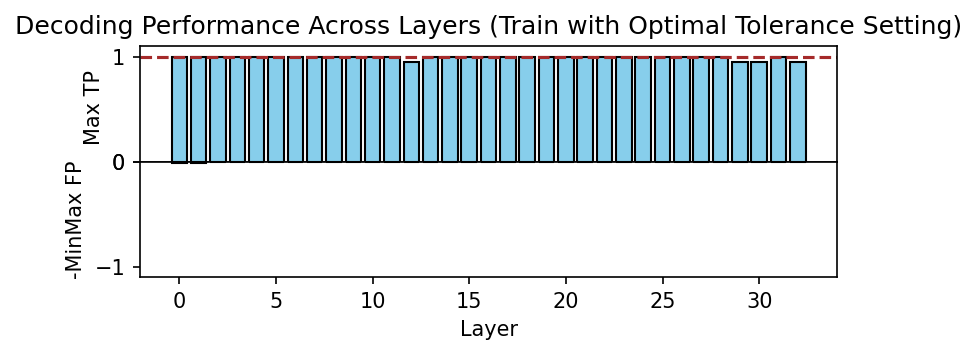

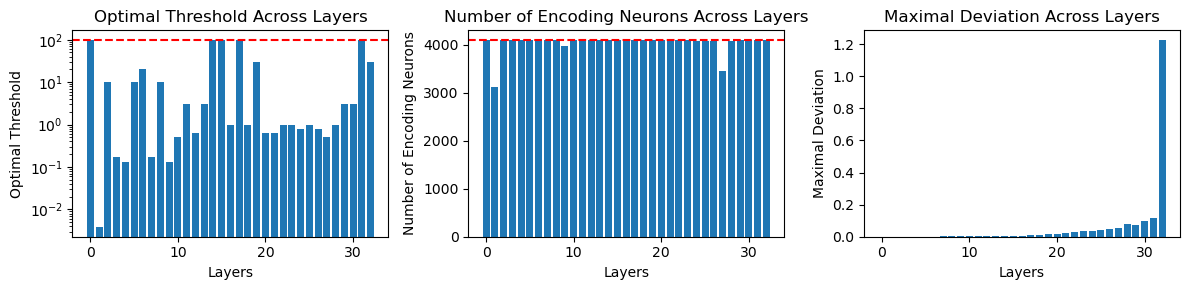

======================================== evaluate on test data ==============================================
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
1.0 0.022556390977443608 0.9778434268833087
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
0.4166666666666667 0.0 0.9896602658788775
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
1.0 0.0 1.0
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
0.75 0.0 0.9955686853766618
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
0.9166666666666666 0.0015037593984962407 0.9970457902511078
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
0.75 0.0 0.9955686853766618
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
1.0 0.0015037593984962407 0.9985228951255539
(1, 677, 4096)
677
[23, 51, 82, 116, 146, 181, 209, 241, 276, 308, 336, 372]
0.9166666666666

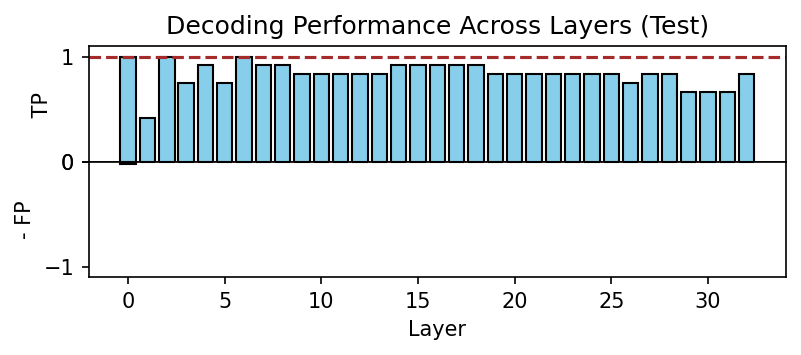

In [7]:
decode_chunks_schema('.', ['schema_train','schema_control_train'], ['schema_test','schema_control_test'], prompt_bank,device, n_training = 10, step = step)